# Week 5 Optimisation example

We are going to focus this example on the single, simplified equation of protein production and degradation,

\begin{equation}
\frac{dS}{dt} = k_s - k_dS \nonumber
\end{equation}

where $S$ is the protein concentration, $k_s$ is the synthesis rate and $k_d$ is the degradation rate. The code for this model can be seen below.

We will go through the following steps:

1. organising data
2. writing a scoring function
3. perform a Latin Hypercube sample to find a good "region" of "parameter space"
4. optimise the reaction rates found from LHS so that the model fits the data.

First let's load the required Python packages.

In [1]:
#import necessary packages
import numpy as np #math and arrays
from scipy.integrate import odeint #differential equations
import matplotlib.pyplot as plt #plotting

# new packages
import scipy.stats.qmc as lhs # for Latin Hypercube sampling (note that other packages exist that can perform this)
from scipy.interpolate import interp1d # for simulation interpolation in your scoring function
import scipy.optimize as opt # for later constrained minimisation

In [2]:
#run a "magic" command to make sure figures are rendered properly in the notebook
%matplotlib inline

The model code is below where the reaction rates are inputs into the function as an array.

In [3]:
def deriv(x, t, ks, kd):

    # Unpack the state variable information
    # The first argument contains the values of the state variables in order
    S = x[0]

    # Calculate the derivatives of the states
    dSdt = ks - kd*S

    # Make a list of all derivatives in the correct order (more useful when you have multiple equations)
    dxdt = [dSdt]

    # Return the derivatives
    return dxdt

### 1: Organising data

In the file $dataForExample.txt$, we have an example triplicate timeseries where $S$ has been measured three times at different timepoints. To use this data within our script we need to read the file and load the data. Download the data from Brightspace and put it in the same directory as this notebook. We can do this with the following code:

In [5]:
# read data for S
data_time, data1, data2, data3 = np.loadtxt("./dataForExample.txt",unpack=True)

We then want to calculate the average and variance at each timepoint. I have then plotted this to show you the data.

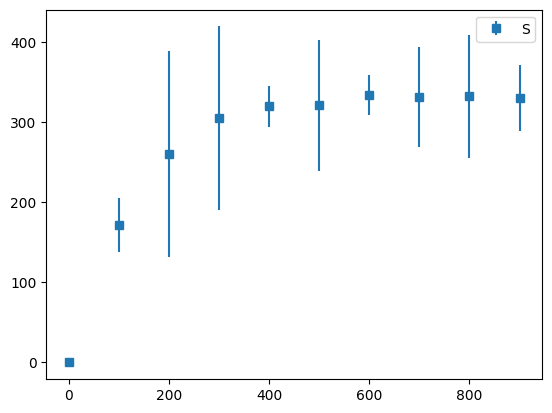

In [7]:
meanS = np.mean([data1, data2, data3],axis=0)
varS = np.var([data1, data2, data3],axis=0)

plt.errorbar(data_time,meanS,varS, marker = 's', linestyle = '', label="S")
plt.legend()
plt.show()

We see from the data that our model needs to be simulated for roughly 1000 timepoints (let's say minutes) and the initial condition is always 0.

### 2: Writing a scoring function

We need to find a way to compare simulated $S$ with our data. This equation is often called a scoring function because, given a parameter set, the comparison between model and data gives a single value. If the value is 0 then the model perfectly matches the average datapoints.

For timeseries data the most common score function to use is

\begin{equation}
\Omega(\boldsymbol{p}) = \sum_{i = t_1}^{t_f} \frac{\big(D(t_i)-M(t_i,\boldsymbol{p})\big)^2}{\sigma(t_i)^2}. \nonumber
\end{equation}

This function has links to Gaussian/Normal distributions in statistics and likelihood functions. These links to statistics make it a good choice for a scoring function as the scores can be related to the probability of a model matching data --- we will not discuss this further here.

In English, what this tells us is that we calculate the square difference between the data, $D$, and simulated time-series, $M$, for $S$ produced by parameter set $\boldsymbol{p}$. This is then divided by the variance of the data at the given timepoint, $\sigma^2$. This calculation is summed up for all timepoints from $t_1$ (ignore the zero timepoint as this has 0 variance in the data and leads to calculation issues) to the final measured timepoint $t_f$.

We can code this with a function that takes as an input the vector of guessed parameters, simulates the model, and outputs a single score comparing the model to the data. In order to use the automated optimisation algorithms later, it is important the function takes this structure.

Note that we only want to compare the simulation and data at the timepoints where the data has been measured. To handle this problem, the simulations are $interpolated$ to obtain simulated values at the required timepoints.

In [10]:
def score_function(ps):

    # Unpack parameters - the reason for using powers is given below.
    ks = 10**ps[0]
    kd = 10**ps[1]

    # set timespan and initial conditions of the system from what we can see in the data
    timespan = np.linspace(0,1000,10001)
    initial_conditions = [0]

    # Simulate the model
    pars = (ks, kd)
    simS = odeint(deriv, initial_conditions, timespan, pars)

    # Interpolate the simulated vector for S
    interp_f = interp1d(timespan,simS[:,0])
    simS_interp = interp_f(data_time)

    # Calculate score ignoring 0 timepoint
    omega = np.sum((meanS[1:]-simS_interp[1:])**2/varS[1:])

    return omega

### 3: Latin Hypercube sampling

We now have everything set up to find the optimal reaction rates for our model to match the data. As shown in the lecture, Latin Hypercube samples take combinations of reaction rates that are equally spread across all possible combinations between lower and upper bounds. Because biological systems contain a wide range of slow and fast processes, it is better to sample this space on a logarithmic scale that treats all magnitudes equally (on a linear scale, faster processes are favoured over slower). For example, we could create bounds that go from $10^{-3}$ to $10$, or -3 to 1. Above in the scoring function the parameters are converted back from log10 to their true values.

I will show here how we can find bounds, create a sample and obtain scores for each set of parameters.

First, to estimate bounds, we need to compare our model with the data by eye. From the ODE we know that the solution is

\begin{equation}
S(t) = \frac{k_s}{k_d} - \bigg(\frac{k_s}{k_d}-S(0)\bigg)e^{-k_dt}. \nonumber
\end{equation}

We can estimate $k_d$ since we can see that the half-time for $S$ accumulation is roughly 100 minutes (the time taken to reach 50\% of steady state $S \approx 300$). This means that $k_d \approx \ln(2)/100 = 0.0069$ and we can set bounds to be between $10^{-3}$ and $10^{-2}$.

For $k_s$ we can then see that the steady state of $S = k_s/k_d \approx 300$. This means that $k_s \approx 2$ so we can set bounds from $10^0$ to $10^1$.

I will then print the best 10 results from our parameter sampling to check that whether or not we are hitting similar parameter sets (i.e. we have found a global minimum in the search space).

In [ ]:
# Set up bounds
lower_bounds = [0,-3]
upper_bounds = [1,-2]

# Create Latin Hypercube sample for d=2 dimensions/parameters
sampler = lhs.LatinHypercube(d=2)
sample = sampler.random(n=100) # n is the number of parameter sets we want to test

# Now, for each row/parameter in the sample matrix, we need to re-scale these using the bounds
for i in range(0, 2):
    sample[:,i] = lower_bounds[i] + (upper_bounds[i]-lower_bounds[i])*sample[:,i]
print(sample)

[[ 0.15863543 -2.96649579]
 [ 0.78327992 -2.53393615]
 [ 0.57047799 -2.07427606]
 [ 0.74197798 -2.77862688]
 [ 0.0166681  -2.64787152]
 [ 0.32870804 -2.86413571]
 [ 0.70863633 -2.41486588]
 [ 0.60598418 -2.15030839]
 [ 0.26031312 -2.7489367 ]
 [ 0.23495011 -2.37218747]
 [ 0.24821805 -2.70771903]
 [ 0.805547   -2.88333238]
 [ 0.28697289 -2.69218846]
 [ 0.5864516  -2.45705   ]
 [ 0.37929201 -2.44103911]
 [ 0.2178316  -2.22470047]
 [ 0.61987895 -2.09241092]
 [ 0.12436498 -2.51541807]
 [ 0.88342091 -2.26455224]
 [ 0.33658366 -2.00395643]
 [ 0.84963224 -2.06565384]
 [ 0.73501919 -2.54251669]
 [ 0.11686532 -2.03958667]
 [ 0.43909354 -2.14345466]
 [ 0.69306012 -2.18613308]
 [ 0.85249811 -2.38856541]
 [ 0.93363255 -2.40783244]
 [ 0.66598264 -2.72433975]
 [ 0.4807006  -2.8720003 ]
 [ 0.18543594 -2.63384459]
 [ 0.64025259 -2.4940393 ]
 [ 0.71367846 -2.27623113]
 [ 0.79987248 -2.80011895]
 [ 0.27178314 -2.52230034]
 [ 0.34063465 -2.10790651]
 [ 0.0793636  -2.93698757]
 [ 0.99858359 -2.67297209]
 

In [ ]:
# Write the for-loop to calculate the score for the 100 parameter sets here

# Create vector to contain the scores
omega = np.zeros((100,2))

# Set up for-loop and execute score_function
for i in range(0,100):
    omega[i,:] = [i,score_function(sample[i,:])]

# Sort omega vector by the 2nd column (the score)
omega = omega[omega[:,1].argsort()]

# Print the best 10 (lowest) scores
print(omega[0:10,:])
# Print the best 10 parameter sets
print(10**sample[omega[0:10,0].astype(int),:])

[[ 37.         163.38593869]
 [ 73.         201.1161124 ]
 [ 88.         214.63321442]
 [ 90.         268.41171415]
 [  9.         314.20747199]
 [ 23.         345.62556545]
 [ 34.         433.26616321]
 [ 17.         445.934453  ]
 [ 52.         454.12820293]
 [  4.         566.87682859]]
[[2.45866636e+00 8.20150436e-03]
 [2.78782152e+00 9.48081509e-03]
 [2.24362016e+00 5.88842965e-03]
 [2.88837225e+00 7.73385076e-03]
 [1.71771104e+00 4.24436314e-03]
 [2.74848606e+00 7.18696188e-03]
 [2.19096103e+00 7.79998002e-03]
 [1.33157299e+00 3.05198175e-03]
 [1.10079823e+00 2.60645204e-03]
 [1.03912573e+00 2.24972005e-03]]


From my sample, I have found parameter set 10 to have the lowest score (9.7) for reaction rates $k_s = 2.69$ and $k_d = 0.008$. This will be our initial guess for the fine-tuning optimisation algorithm. We see here also that our best hits do not haev similar $k_s$ and $k_d$ values meaning that we may have local minima in the search space where simulations look good even if we have not found precisely the true reaction rate values.

### 4: Optimisation

Using the best reaction rates from the Latin Hypercube sample, we have a starting point for our optimisation algorithm to fine-tune and find the optimal result. We will assume that the optimal result exists close to our best LHS parameter set and alter our bounds accordingly. The following script shows how to code this.

In [ ]:
# Take the best reaction rates from LHS as our initial guess
init_p = sample[omega[0,0].astype(int),:]

# Change the bounds to be "local" to the initial guess
bounds = opt.Bounds(init_p-0.5,init_p+0.5)

# Perform optimisation
opt_score = opt.minimize(score_function,init_p,method='L-BFGS-B',bounds=bounds,options={'disp':True,'maxiter':1000})
print(opt_score)

# Optimal parameter set on linear scale
print(10**opt_score.x)

      fun: 2.6005166511046203
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([16.67512671, 74.32013348])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 321
      nit: 25
     njev: 107
   status: 0
  success: True
        x: array([ 0.39823152, -2.12578811])
[2.50167865 0.00748535]


In [ ]:
# Take the best reaction rates from LHS as our initial guess
init_p = sample[omega[1,0].astype(int),:]

# Change the bounds to be "local" to the initial guess
bounds = opt.Bounds(init_p-0.5,init_p+0.5)

# Perform optimisation
opt_score = opt.minimize(score_function,init_p,method='L-BFGS-B',bounds=bounds,options={'disp':True,'maxiter':1000})
print(opt_score)

# Optimal parameter set on linear scale
print(10**opt_score.x)

      fun: 2.437317367968555
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01739546,  0.06511103])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 288
      nit: 25
     njev: 96
   status: 0
  success: True
        x: array([ 0.39097342, -2.1339404 ])
[2.46021702 0.00734615]


We see here that the score has decreased/improved from 9 to 2 and the optimal reaction rates have also been tweaked to give $k_s = 2.46$ and $k_d = 0.0073$.

With these reaction rates, we can now simulate our model and see if the time-series really matches the data.

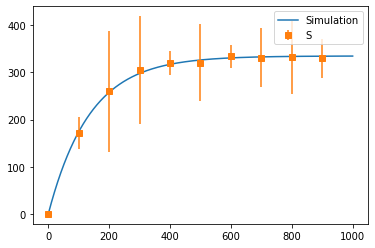

In [ ]:
# Unpack parameters - the reason for using powers is given below.
ks = 10**opt_score.x[0]
kd = 10**opt_score.x[1]

# set timespan and initial conditions of the system from what we can see in the data
timespan = np.linspace(0,1000,10001)
initial_conditions = [0]

# Simulate the model
pars = (ks, kd)
simS = odeint(deriv, initial_conditions, timespan, pars)

plt.plot(timespan,simS[:,0],label="Simulation")
plt.errorbar(data_time,meanS,varS, marker = 's', linestyle = '', label="S")
plt.legend()
plt.show()

We see that the model matches our data very nicely! Without further experiments being conducted to falsify our model, we can say that our model represents reality well enough we can make some experimental predictions and conclusions about the system!